# Одностадийная детекция. Домашняя работа

В рамках данной домашней работы вы закрепите свои знания о процессе разработки и улучшения модели одностадийной детекции YOLO.

А именно:

* Вы поработаете с платформой Roboflow.

* Проведете предобработку и анализ данных.

* Самостоятельно реализуете аугментации Mosaic и Mixup.

* Выполните серию экспериментов по обучению модели, включая использование аугментаций, настройку гиперпараметров и добавление новых данных.

* Освоите методы визуализации ошибок предсказаний модели и расчета IoU между предсказанными и истинными bounding box.

* В качестве финального проекта обучите модель, применяя все изученные техники.

## Задание №1. (0.5 балла) Работа с Roboflow

Описание:
* Зарегистрируйтесь на платформе Roboflow
* Скачайте [датасет](https://universe.roboflow.com/alexandre-b2d69/first-ugfem) в формате YOLOv9
* Изучите структуру датасета и опишите её в отчёте

Цель:
* Понять основы работы с Roboflow и структуру данных YOLO

In [51]:
import os

In [52]:
# Выгрузите датасет в папку datasets

#%%capture --no-display
# !curl -L "https://universe.roboflow.com/ds/Gd7cIyfsFm?key=NOWI2Udg7L" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !mv datasets/data.yaml .

In [53]:
# Выведите информацию о датасете

!cat data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['airplane']

roboflow:
  workspace: alexandre-b2d69
  project: first-ugfem
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/alexandre-b2d69/first-ugfem/dataset/1

In [54]:
# Выведите количество изображений отдельно по каждому сплиту и их суммарное количество
c = 0
for x in ['datasets/train', 'datasets/valid', 'datasets/test']:
    l = len(os.listdir(os.path.join(x, 'images')))
    c += l
    print(f"{x.split('/')[1]}: {l} images")
print(f"Overall: {c}")

train: 699 images
valid: 66 images
test: 34 images
Overall: 799


## Задание №2. (1 балл) Предварительная обработка данных и визуализация

Описание:
* Напишите скрипт для визуализации аннотаций на изображениях
* Визуализируйте и проанилизируйте несколько изображений с аннотациями
* Подсчитайте количество объектов каждого класса и визуализируйте результаты (гистограмма или круговая диаграмма)

Цель:
* Научиться визуализировать данные и понимать распределение классов.

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from PIL import Image
import numpy as np

In [56]:
# Функция, возвращающая изображение с отрисованными аннотациями
def visualize(image_path, annotation_path):
    classNames = ['airplane']

    frame = cv2.imread(image_path)[...,::-1].copy() # BGR -> RGB

    coordinates = []
    with open(annotation_path, "r") as lines:
        for line in lines:
            hT, wT, _ = frame.shape
            coordinates = line.rstrip('\n').split(' ')

            x1,y1,w2,h2 = float(coordinates[1]), float(coordinates[2]), float(coordinates[3]), float(coordinates[4])

            # Переведите относительные значения координат в абсолютные
            
            w, h = int(w2 * wT), int(h2 * hT)
            x, y = int((x1 * wT) - (w / 2)), int((y1 * hT) - (h / 2))

            cls = coordinates[0]

            # Получаем цвет для класса
            cmap = plt.get_cmap('tab20b')
            colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
            color = colors[int(cls) % len(colors)]
            color = [i * 255 for i in color]

            # Отрисовываем на изображении ббокс и название класса
            cv2.rectangle(frame, (x,y), (x+w, y+h), color, 1)
            cv2.rectangle(frame, (x,y-30), (x+len(classNames[int(cls)]*15), y), color,-1)
            cv2.putText(frame,str(classNames[int(cls)]), (x+4, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    return Image.fromarray(frame)

# Получите абсолютные пути до тестовых изображений и аннотаций
test_images = [os.path.join("datasets/test/images", x) for x in sorted(os.listdir('datasets/test/images/'))]
test_annotations = [os.path.join("datasets/test/labels", x) for x in sorted(os.listdir('datasets/test/labels/'))]

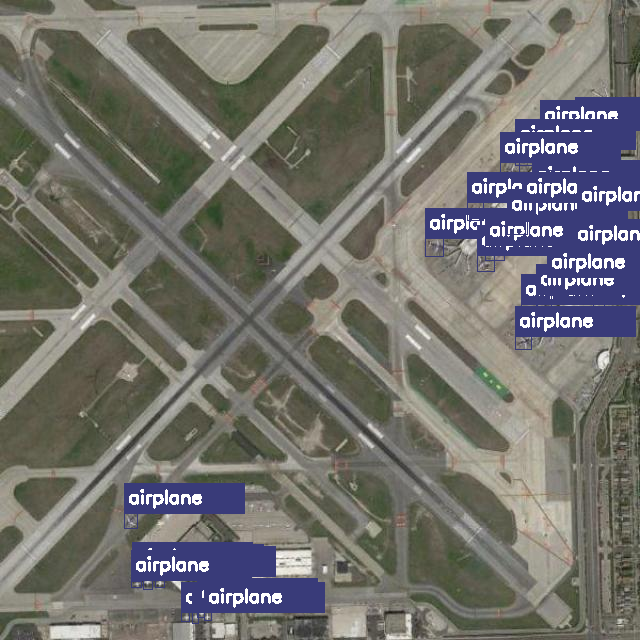

In [57]:
# Визуализируйте разметку на одном из примеров из тестового датасета

idx = 0

image = visualize(test_images[0], test_annotations[0])
image

In [58]:
# Функция для подсчёта количества классов в аннотациях
def class_count(annotations_path):
    class_names = ['airplane']
    cls_count = {x: 0 for x in class_names}
    for ann_path in annotations_path:
        with open(ann_path, 'r') as file:
            for line in file:
                cls, _, _, _, _ = map(float, line.strip().split())
                cls_count[class_names[int(cls)]] += 1

    return cls_count

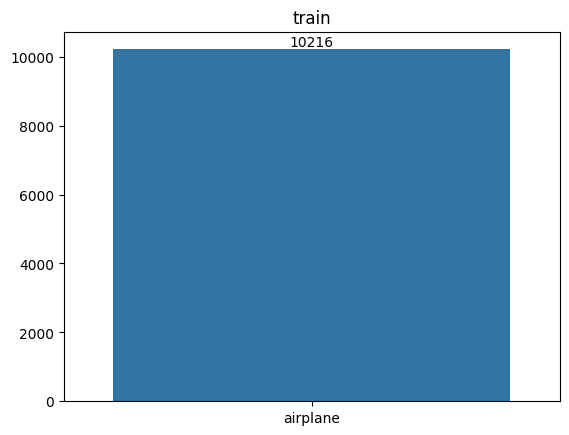

In [59]:
# Получите абсолютные пути до тренировочных аннотаций
train_annotations = [os.path.join("datasets/train/labels", x) for x in sorted(os.listdir('datasets/train/labels/'))]

# Подсчитайте количество присутствий классов в аннотациях
train_cls_count = class_count(train_annotations)

# Выведите барплот количества размеченных ббоксов в трейновой выборке
ax = sns.barplot(data=train_cls_count)
ax.bar_label(ax.containers[0])
ax.set_title('train')
plt.show()

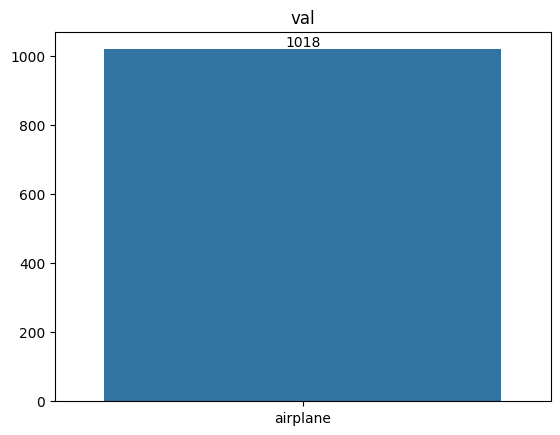

In [60]:
# Получите абсолютные пути до валидационных аннотаций
val_annotations = [os.path.join("datasets/valid/labels", x) for x in sorted(os.listdir('datasets/valid/labels/'))]

# Подсчитайте количество присутствий классов в аннотациях
val_cls_count = class_count(val_annotations)

# Выведите барплот количества размеченных ббоксов в валидационной выборке
ax = sns.barplot(data=val_cls_count)
ax.bar_label(ax.containers[0])
ax.set_title('val')
plt.show()

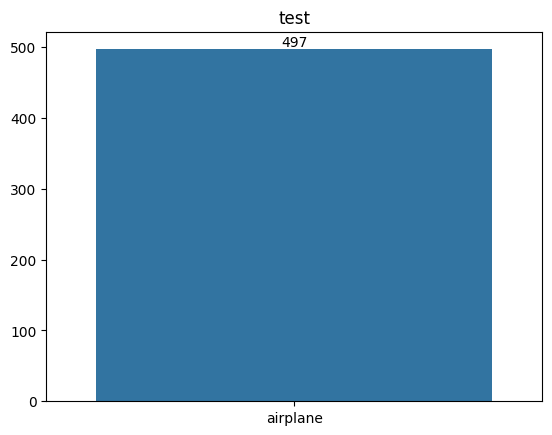

In [61]:
# Получите абсолютные пути до тестовых аннотаций
#test_annotations = # <YOUR CODE HERE> #

# Подсчитайте количество присутствий классов в аннотациях
test_cls_count = class_count(test_annotations)

# Выведите барплот количества размеченных ббоксов в тестовой выборке
ax = sns.barplot(data=test_cls_count)
ax.bar_label(ax.containers[0])
ax.set_title('test')
plt.show()

In [62]:
# Функция для подсчета количества и среднего относительного размера bounding box в каждом файле аннотаций
def count_bboxes_and_relative_size(annotation_files):
    bbox_counts = []
    relative_sizes = []

    for annotation_file in annotation_files:
        with open(annotation_file, 'r') as f:
            lines = f.readlines()
            if not lines:
                continue

            bboxes = [list(map(float, line.split()[1:])) for line in lines]

            bbox_counts.append(len(bboxes))

            sizes = [bbox[2] * bbox[3] for bbox in bboxes]
            relative_sizes.append(sum(sizes) / len(bboxes))

    return bbox_counts, relative_sizes

# Подсчитайте количество и средние относительные размеры bounding box для каждого сплита
train_bbox_counts, train_relative_sizes = count_bboxes_and_relative_size(train_annotations)
val_bbox_counts, val_relative_sizes = count_bboxes_and_relative_size(val_annotations)
test_bbox_counts, test_relative_sizes = count_bboxes_and_relative_size(test_annotations)

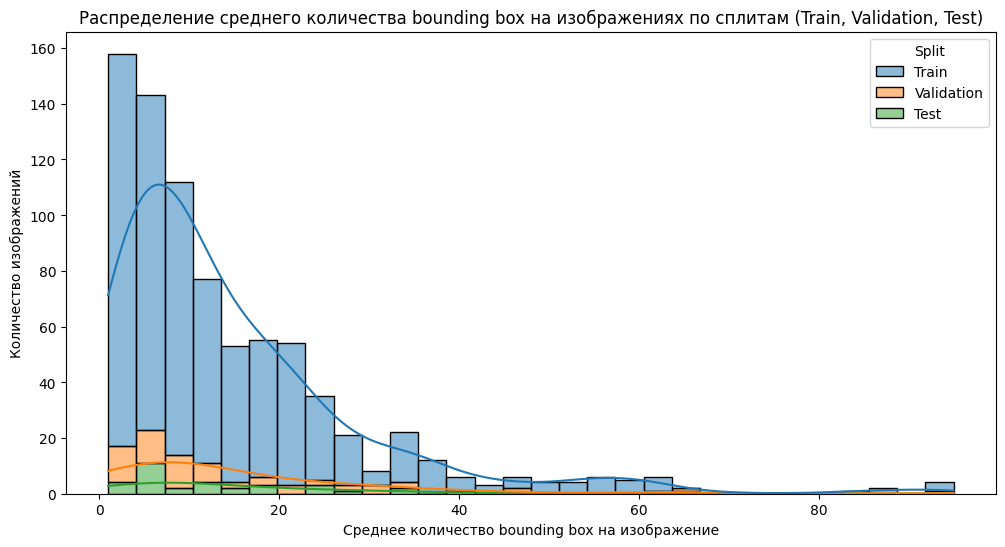

In [63]:
# Создайте DataFrame для визуализации количества bounding box
data = {
    'Split': ['Train'] * len(train_bbox_counts) + ['Validation'] * len(val_bbox_counts) + ['Test'] * len(test_bbox_counts),
    'Bounding Boxes': train_bbox_counts + val_bbox_counts + test_bbox_counts
}
df = pd.DataFrame(data)

# Выведите гистограмму распределения
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Bounding Boxes', hue='Split', multiple='stack', kde=True, cbar=True)

plt.xlabel('Среднее количество bounding box на изображение')
plt.ylabel('Количество изображений')
plt.title('Распределение среднего количества bounding box на изображениях по сплитам (Train, Validation, Test)')
plt.show()

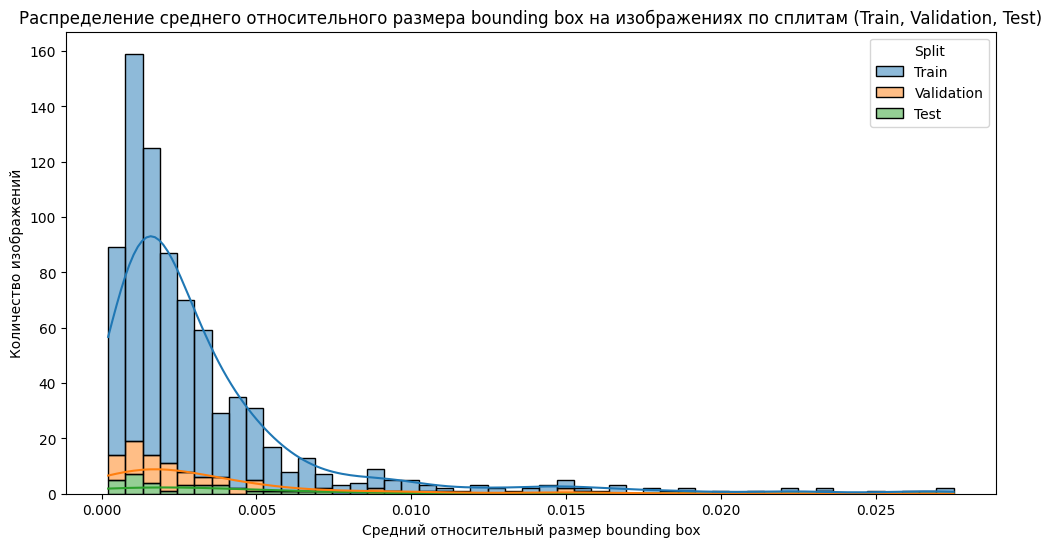

In [64]:
# Создайте DataFrame для визуализации средних относительных размеров bounding_box
data = {
    'Split': ['Train'] * len(train_relative_sizes) + ['Validation'] * len(val_relative_sizes) + ['Test'] * len(test_relative_sizes),
    'Relative Bounding Box Size': train_relative_sizes + val_relative_sizes + test_relative_sizes
}
df = pd.DataFrame(data)

# Выведите гистограмму распределения
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Relative Bounding Box Size', hue='Split', multiple='stack', kde=True, cbar=True)

plt.xlabel('Средний относительный размер bounding box')
plt.ylabel('Количество изображений')
plt.title('Распределение среднего относительного размера bounding box на изображениях по сплитам (Train, Validation, Test)')
plt.show()

## Задание №3. (1 балл) Реализация аугментации Mosaic

Описание задания:

* Изучите принцип работы аугментации Mosaic.

* Реализуйте функцию, которая будет применять Mosaic аугментацию к изображениям.

* Примените эту функцию к нескольким изображениям из обучающего набора данных и визуализируйте полученные результаты.

Цель задания:

* Разобраться в технике аугментации данных и самостоятельно реализовать её для улучшения качества обучения модели.

Рассмотрим подробнее дополнительный функционал для корректной работы аугментаций

1. preprocess(image_name, image_dir, label_dir)
  - Описание:
Эта функция формирует пути к изображениям и аннотациям на основе имени файла изображения, директорий для изображений и аннотаций
  - Аргументы:
      * image_name (str): Имя файла изображения
      * image_dir (str): Директория, где хранятся изображения
      * label_dir (str): Директория, где хранятся аннотации
  - Возвращает:
      * image_path (str): Полный путь к изображению
      * label_path (str): Полный путь к файлу с аннотациями
      * label_name (str): Имя файла аннотаций
2. draw_rect(img, bboxes, class_labels)
  - Описание:
Эта функция рисует bounding box на изображении для визуализации объектов.
  - Аргументы:
      * img (numpy.ndarray): Изображение.
      * bboxes (list): Список bounding box в формате YOLO [center_x, center_y, width, height].
      * class_labels (list): Список классов объектов
  - Возвращает:
      * img (numpy.ndarray): Изображение с нарисованными bounding box
3. read_img(image_path, cvt_color=True)
  - Описание:
Эта функция загружает изображение и, при необходимости, конвертирует его цвета из BGR в RGB
  - Аргументы:
      * image_path (str): Путь к изображению
      * cvt_color (bool): Флаг для конвертации цвета (по умолчанию — True)
  - Возвращает:
      * img (numpy.ndarray): Изображение
4. save_img(image, save_path, jpg_quality=None)
  - Описание:
Эта функция сохраняет изображение с опциональным указанием качества JPEG
  - Аргументы:
      * image (numpy.ndarray): Изображение
      * save_path (str): Путь для сохранения изображения
      * jpg_quality (int, optional): Качество JPEG (по умолчанию — None)
  - Возвращает:
      * None
5. display_img(image_path, label_path)
  - Описание:
Эта функция загружает изображение и соответствующие аннотации, рисует bounding box и подготавливает изображение для отображения
  - Аргументы:
      * image_path (str): Путь к изображению
      * label_path (str): Путь к файлу с аннотациями
  - Возвращает:
      * img (numpy.ndarray): Изображение с нарисованными bounding box в формате, готовом для отображения
6. read_label(label_path)
  - Описание:
Эта функция считывает bounding box и метки классов из файла аннотаций в формате YOLO
  - Аргументы:
      * label_path (str): Путь к файлу с аннотациями
  - Возвращает:
      * bboxes (list): Список bounding box
      * class_labels (list): Список классов объектов
7. save_label(bboxes, class_labels, label_path)
  - Описание:
Эта функция сохраняет bounding box и метки классов в файл в формате YOLO
  - Аргументы:
      * bboxes (list): Список bounding box
      * class_labels (list): Список классов объектов
      * label_path (str): Путь для сохранения файла с аннотациями
  - Возвращает:
      * None

Эти функции помогут вам организовать предварительную обработку и сохранение данных для аугментации изображений. Также они обеспечат конвертацию, визуализацию и сохранение изображений и аннотаций, что крайне важно для отладки и анализа результатов

In [65]:
import albumentations as A
import random

In [66]:
# Дополнительный функционал для корректной работы аугментации

def preprocess(image_name, image_dir, label_dir):
    image_path = os.path.sep.join([image_dir, image_name])

    name = image_name.split('.jpg')[0]
    label_name = name + '.txt'
    label_path = os.path.sep.join([label_dir, label_name])

    return image_path, label_path, label_name

def draw_rect(img, bboxes, class_labels):
    colors = {0: (255,0,0)}

    img = img.copy()
    height, width = img.shape[:2]
    for bbox, cls in zip(bboxes, class_labels):
        center_x, center_y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        x = int((center_x - w/2) * width)
        w = int(w * width)
        y = int((center_y - h/2) * height)
        h = int(h * height)

        color = colors[int(cls)]

        img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 1)
    return img

def read_img(image_path, cvt_color=True):
    img = cv2.imread(image_path)
    if cvt_color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def save_img(image, save_path, jpg_quality=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if jpg_quality:
        cv2.imwrite(save_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
    else:
        cv2.imwrite(save_path, image)

def display_img(image_path, label_path):
    img = read_img(image_path, cvt_color=False)
    bboxes, class_labels = read_label(label_path)
    img = draw_rect(img, bboxes, class_labels)

    return img[...,::-1]

def read_label(label_path):
    with open(label_path) as f:
        conts = f.readlines()

    bboxes = []
    class_labels = []
    for cont in conts:
        cont = cont.strip().split()

        center_x, center_y, w, h = float(cont[1]), float(cont[2]), float(cont[3]), float(cont[4])
        bboxes.append([center_x, center_y, w, h])
        class_labels.append(cont[0])
    return (bboxes, class_labels)

def save_label(bboxes, class_labels, label_path):
    tem_lst = []
    for i, bbox in enumerate(bboxes):
        tem_lst.append(class_labels[i] + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')

    with open(label_path, 'w') as f:
        f.writelines(tem_lst)

In [67]:
# Функция для рандомного кропа изображения с учётом ббоксов
def random_crop_savebboxes(image_name, image_dir, label_dir, expected_h, expected_w):
    image_path, label_path, _ =  preprocess(image_name, image_dir, label_dir)

    (bboxes, class_labels) = read_label(label_path)

    transform = A.Compose([A.RandomResizedCrop(expected_h, expected_w)],
                           bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_area=1, min_visibility=0.1))

    transformed = transform(image=read_img(image_path), bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']

    return transformed_image, transformed_bboxes, transformed_class_labels

# Функция аугментации
def mosaic(image_file_list, image_dir, label_dir, output_image_dir, output_label_dir, scale_x, scale_y):
    # Создайте новое изображение размером (640,640,3) с dtype=uint8
    new_img = np.zeros((640, 640, 3), dtype=np.uint8)

    # Находим центральную точку мозаики
    div_point_x = int(640 * scale_x)
    div_point_y = int(640 * scale_y)

    # Итерируемся по нашим изображениям
    for i in range(len(image_file_list)):

        # Левое верхнее изображение, img_0
        if i == 0:

            # Ширина и высота левого верхнего изображения
            w0 = div_point_x
            h0 = div_point_y
            img_0, bboxes_0, class_labels_0 = random_crop_savebboxes(image_file_list[0], image_dir, label_dir, h0, w0)

            # Левое верхнее изображение
            new_img[:div_point_y, :div_point_x, :] = img_0
            
            # Изменяем оригинальные ббоксы
            if len(bboxes_0) == 0:  # ббоксы отсутствуют
                bboxes_0_new = []
            else:
                bboxes_0_new = np.zeros((len(bboxes_0), 4))
                bboxes_0_new = bboxes_0_new.tolist()

            for i, box in enumerate(bboxes_0):
                
                bboxes_0_new[i][0] = box[0] * scale_x # x_center
                bboxes_0_new[i][2] = box[2] * scale_x # w

                bboxes_0_new[i][1] = box[1] * scale_y # y_center
                bboxes_0_new[i][3] = box[3] * scale_y # h

        # Верхнее правое изображение, img_1
        elif i == 1:

            # Ширина и высота правого верхнего изображения
            w1 = 640 - div_point_x
            h1 = div_point_y
            img_1, bboxes_1, class_labels_1 = random_crop_savebboxes(image_file_list[1], image_dir, label_dir, h1, w1)
            new_img[:div_point_y, div_point_x:, :] = img_1

            # Изменяем оригинальные ббоксы
            if len(bboxes_1) == 0: # ббоксы отсутствуют
                bboxes_1_new = []
            else:
                bboxes_1_new = np.zeros((len(bboxes_1), 4))
                bboxes_1_new = bboxes_1_new.tolist()

            for i, box in enumerate(bboxes_1):
                bboxes_1_new[i][0] = box[0] * (1 - scale_x) + scale_x # x_center
                bboxes_1_new[i][2] = box[2] * (1 - scale_x) # w

                bboxes_1_new[i][1] = box[1] * scale_y # y_center
                bboxes_1_new[i][3] = box[3] * scale_y # h

        # Нижнеее левое изображение, img_2
        elif i == 2:

            # Ширина и высота нижнего левого изображения
            w2 = div_point_x
            h2 = 640 - div_point_y
            img_2, bboxes_2, class_labels_2 = random_crop_savebboxes(image_file_list[2], image_dir, label_dir, h2, w2)
            new_img[div_point_y:, :div_point_x, :] = img_2

            # Изменяем оригинальные ббоксы
            if len(bboxes_2) == 0: # ббоксы отсутствуют
                bboxes_2_new = []
            else:
                bboxes_2_new = np.zeros((len(bboxes_2), 4))
                bboxes_2_new = bboxes_2_new.tolist()

            for i, box in enumerate(bboxes_2):
                bboxes_2_new[i][0] =  box[0] * scale_x   # x_center
                bboxes_2_new[i][2] =  box[2] * scale_x  # w

                bboxes_2_new[i][1] =  box[1] * (1 - scale_y) + scale_y # y_center
                bboxes_2_new[i][3] =  box[3] * (1 - scale_y)# h

        # Нижнее правое изображение, img_3
        else:

            # Ширина и высота правого нижнего изображения
            w3 = 640 - div_point_x
            h3 = 640 - div_point_y
            img_3, bboxes_3, class_labels_3 = random_crop_savebboxes(image_file_list[3], image_dir, label_dir, h3, w3)
            new_img[div_point_y:, div_point_x:, :] = img_3

            # Изменяем оригинальные ббоксы
            if len(bboxes_3) == 0:  # ббоксы отсутствуют
                bboxes_3_new = []
            else:
                bboxes_3_new = np.zeros((len(bboxes_3), 4))
                bboxes_3_new = bboxes_3_new.tolist()

            for i, box in enumerate(bboxes_3):
                bboxes_3_new[i][0] = box[0] * (1 - scale_x) + scale_x  # x_center
                bboxes_3_new[i][2] = box[2] * (1 - scale_x) 

                bboxes_3_new[i][1] = box[1] * (1 - scale_y) + scale_y# y_center
                bboxes_3_new[i][3] =  box[3] * (1 - scale_y)  # h

    # Получите все классы аугментированного изображения
    new_class_labels = class_labels_0 + class_labels_1 + class_labels_2 + class_labels_3
    # Получите все ббоксы аугментированного изображения
    new_bboxes =  bboxes_0_new + bboxes_1_new + bboxes_2_new + bboxes_3_new

    # пути для сохранения аугментированного изображения и аннотаций
    image_store_path = os.path.sep.join([output_image_dir, 'mosaic.jpg'])
    label_store_path = os.path.sep.join([output_label_dir, 'mosaic.txt'])

    # сохраняем аугментированные изображения и аннотации
    save_img(new_img, image_store_path)
    save_label(new_bboxes, new_class_labels, label_store_path)

    # отрисовываем аннотации на аугментированном изображении
    res = display_img(image_store_path, label_store_path)

    return res

In [68]:
# Создайте папки для хранения аугментированных изображений и соответствующих аннотаций

output_image_dir = 'augmentation/mosaic_images'
if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)

output_label_dir = 'augmentation/mosaic_labels'
if not os.path.exists(output_label_dir):
    os.makedirs(output_label_dir)

# Пути до оригинальных изображений и аннотаций
image_dir = 'datasets/test/images/'
label_dir = 'datasets/test/labels/'

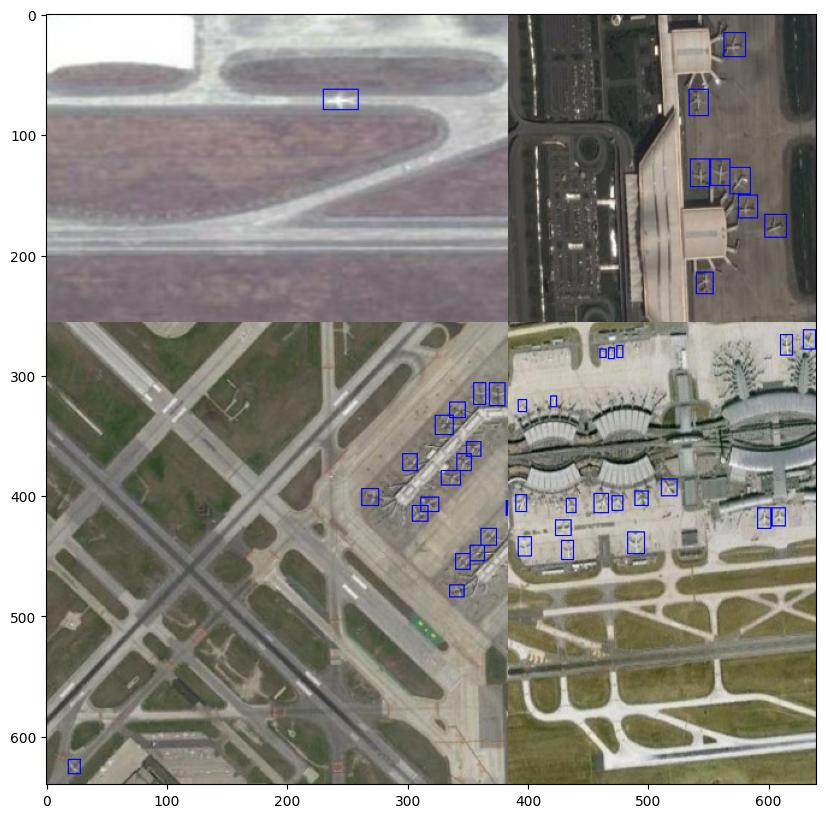

In [75]:
# Рандомно выберите 4 изображения
image_file_list = np.random.choice(os.listdir(image_dir)[:4], size=4, replace=False).tolist()

# Задаём ширину и высоту левой верхней картинки
scale_x = 0.6
scale_y = 0.4

# Аугментируйте
res =  mosaic(image_file_list, image_dir, label_dir, output_image_dir, output_label_dir, scale_x, scale_y)

plt.figure(figsize=(10,10))
plt.imshow(res)

## Задание №4. (1 балл) Реализация аугментации Mixup

Описание:
* Изучите технику аугментации Mixup
* Реализуйте функцию для применения Mixup аугментации на изображениях
* Примените эту функцию к нескольким изображениям из тренировочного набора и визуализируйте результаты

Цель:
* Глубже понять и реализовать другую популярную технику аугментации данных

In [84]:
# Функция аугментации
def mixup_augmentation(image_path1, annotation_path1, image_path2, annotation_path2, mixup_alpha=0.7):
    # Загрузите изображения и аннотации
    image1 = read_img(image_path1)
    image2 = read_img(image_path2)
    bboxes1, class_labels1 = read_label(annotation_path1)
    bboxes2, class_labels2 = read_label(annotation_path2)

    # Вычислите λ из бета-распределения
    lambda_value = np.random.beta(mixup_alpha, mixup_alpha)

    # Создайте миксап изображение (dtype=np.uint8)
    mixup_image = (lambda_value * image1 + (1 - lambda_value) * image2).astype(np.uint8)

    # Комбинирование аннотаций
    mixup_bboxes = bboxes1 + bboxes2
    mixup_labels = class_labels1 + class_labels2

    return mixup_image, mixup_bboxes, mixup_labels

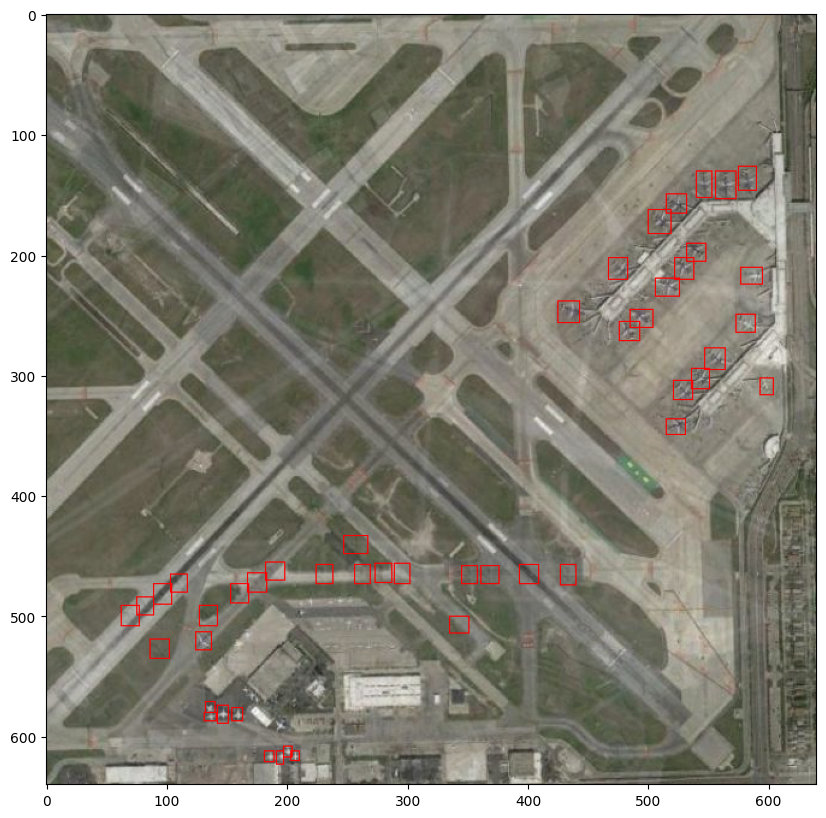

In [85]:
# Пример использования

image_path1 = test_images[0]
annotation_path1 = test_annotations[0]
image_path2 = test_images[1]
annotation_path2 = test_annotations[1]

# Аугментируйте
mixup_image, mixup_bboxes, mixup_labels =  mixup_augmentation(image_path1, annotation_path1, image_path2, annotation_path2)

# Отрисуйте аннотации
res = draw_rect(mixup_image, mixup_bboxes, mixup_labels)

plt.figure(figsize=(10,10))
plt.imshow(res)

## Задание №5. (0 баллов)Установка и подготовка YOLOv9

Описание:
* Установите библиотеку ultralytics для работы с YOLOv9
* Настройте необходимые зависимости и убедитесь, что всё корректно установлено

Цель:
* Ознакомиться с библиотекой ultralytics и подготовиться к обучению модели

In [87]:
%%capture --no-display
!pip install ultralytics
!pip install dill

In [88]:
# Импортируйте библиотеку YOLO

from ultralytics import YOLO

In [89]:
# Попробуйте инициализировать модель

model =  YOLO("yolov9s.pt")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 14.7M/14.7M [00:00<00:00, 29.1MB/s]


## Задание №6. (1 балл) Базовое обучение модели YOLOv9





Описание:
* Используя загруженный датасет и модель YOLOv9, обучите модель на 10 эпохах без аугментаций
* Выведите метрики на тестовом наборе данных
* Визуализируйте результаты обучения (например, графики изменения loss и mAP)

Цель:
* Научиться базовому обучению модели YOLOv9 и анализу результатов

In [ ]:
augm = {
    # Отключите аугментации

    "close_mosaic":  # <YOUR CODE HERE> #
    "hsv_h":  # <YOUR CODE HERE> #
    "hsv_s":  # <YOUR CODE HERE> #
    "hsv_v":  # <YOUR CODE HERE> #
    "degrees":  # <YOUR CODE HERE> #
    "fliplr":  # <YOUR CODE HERE> #
    "mosaic":  # <YOUR CODE HERE> #
    "mixup":  # <YOUR CODE HERE> #
}

In [ ]:
# Инициализируйте модель

model =  # <YOUR CODE HERE> #

In [ ]:
# Обучите модель. Не забудьте передать augm

results =  # <YOUR CODE HERE> #

In [ ]:
# Инициализируйте модель лучшим чекпоинтом (все логи и промежуточные итоги сохраняются в папке runs)

model =  # <YOUR CODE HERE> #

In [ ]:
# Вычислите метрики на тестовом наборе данных

metrics =  # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте графики обучения (можно найти в папке runs)

 # <YOUR CODE HERE> #

## Задание №7. (1 балл) Функция для расчёта IoU и отрисовки ошибок предсказаний модели YOLOv9

Описание:
* Реализуйте функцию, которая отображает на изображении предсказанные bounding box модели YOLOv9 и сравнивает их с аннотациями. Предсказанные bounding box отображаются одним цветом, а реальные — другим
* Воспользуйтесь функцией box_iou из библиотеки torchvision.ops для вычисления IoU между предсказанными и реальными bounding box

Цель:
* Научиться визуализировать и анализировать ошибки предсказаний модели

In [ ]:
import torch
from torchvision.ops import box_iou

In [ ]:
# Вспомогательная функция для преобразования YOLO bbox к формату [x1, y1, x2, y2]
def yolo_to_xyxy(bbox, width, height):
    center_x, center_y, w, h = bbox
    x1 = # <YOUR CODE HERE> #
    y1 = # <YOUR CODE HERE> #
    x2 = # <YOUR CODE HERE> #
    y2 = # <YOUR CODE HERE> #
    return [x1, y1, x2, y2]

# Вспомогательная функция для предсказания модели YOLOv9
def get_predictions(model, image, conf_thr=0.25):
    results = model(image)
    predictions = []

    for idx, pred in enumerate(results[0].boxes.xyxy):
        conf = # <YOUR CODE HERE> #
        if conf > conf_thr:
            x1, y1, x2, y2 = pred.cpu()
            cls = # <YOUR CODE HERE> #
            predictions.append([x1, y1, x2, y2, int(cls)])

    return predictions

# Основная функция для отрисовки ошибок
def draw_errors(predictions, gt_bboxes, img, width, height):
    pred_color = (0, 255, 0)  # Зеленый для предсказанных BB
    gt_color = (0, 0, 255)    # Красный для реальных BB (инвертируется при BGR -> RGB)

    for bbox in predictions:
        x1, y1, x2, y2, cls = bbox
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), pred_color, 2)

    for gt_bbox in gt_bboxes:
        x1, y1, x2, y2 = yolo_to_xyxy(gt_bbox, width, height)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), gt_color, 2)

    return img

# Вспомогательная функция для вычисления IoU и отрисовки ошибок
def visualize_predictions(model, image_path, label_path, conf_thr=0.25):
    img = read_img(image_path, cvt_color=False)
    gt_bboxes, _ = read_label(label_path)
    height, width = img.shape[:2]

    # Преобразуйте реальные bbox к формату xyxy
    gt_bboxes_xyxy = # <YOUR CODE HERE> #

    # Получите предсказаний модели
    predictions = # <YOUR CODE HERE> #

    if len(predictions) > 0 and len(gt_bboxes_xyxy) > 0:
        pred_boxes_tensor = torch.tensor([pred[:4] for pred in predictions])
        gt_boxes_tensor = torch.tensor(gt_bboxes_xyxy)

        # Вычислите IoU
        iou = box_iou(pred_boxes_tensor, gt_boxes_tensor) # [MxN] pairwise iou matrix
        mean_iou = torch.max # <YOUR CODE HERE> #

        print(f'\nMean IoU = {mean_iou}')

    # Отрисуйте ошибки
    img_with_errors = # <YOUR CODE HERE> #

    return img_with_errors

In [ ]:
# Задайте путь к изображению и аннотациям
image_path = test_images[0]
label_path = test_annotations[0]

# Загрузите предобученные веса в модель
model = # <YOUR CODE HERE> #

# Получите изображение с визуализированными предсказаниями и реальной разметкой
img_with_errors = # <YOUR CODE HERE> #

# Выведите полученное изображение
img_rgb = cv2.cvtColor(img_with_errors, cv2.COLOR_BGR2RGB)
Image.fromarray(img_rgb)

## Задание №8. (1 балл)  Применение аугментаций к обучению

Описание:
* Проведите обучение на тех же 10 эпохах с применением аугментаций(Mosaic, Mixup)
* Сравните результаты обучения с предыдущей моделью без аугментаций
* Проанализируйте результаты обучения по сравнению с заданием №7, попробуйте интерпретировать влияние аугментаций на процесс обучения и сформируйте письменный отчёт

Цель:
* Понять влияние аугментаций на улучшение качества модели

In [ ]:
augm = {
    # Включите аугментации

    "close_mosaic":  # <YOUR CODE HERE> #
    "hsv_h":  # <YOUR CODE HERE> #
    "hsv_s":  # <YOUR CODE HERE> #
    "hsv_v":  # <YOUR CODE HERE> #
    "degrees":  # <YOUR CODE HERE> #
    "fliplr":  # <YOUR CODE HERE> #
    "mosaic":  # <YOUR CODE HERE> #
    "mixup":  # <YOUR CODE HERE> #
}

In [ ]:
# Инициализируйте модель

model =  # <YOUR CODE HERE> #

In [ ]:
# Обучите модель. Не забудьте передать augm

results =  # <YOUR CODE HERE> #

In [ ]:
# Инициализируйте модель лучшим чекпоинтом (все логи и промежуточные итоги сохраняются в папке runs)

model =  # <YOUR CODE HERE> #

In [ ]:
# Вычислите метрики на тестовом наборе данных

metrics =  # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте графики обучения (можно найти в папке runs)

 # <YOUR CODE HERE> #

## Задание №9. (1 балл) Тюнинг гиперпараметров

Описание:
* Исследуйте гиперпараметры модели YOLOv9 (learning rate, batch size, etc.)
* Проведите несколько экспериментов с различными значениями параметров
* Сравните результаты с заданием №7 и сформулируйте письменный вывод о том, какой набор параметров дал лучшие результаты

Цель:
* Понять влияние гиперпараметров на обучение модели и уметь их настроить

In [ ]:
hyps = {
    # Отключите аугментации

    "close_mosaic":  # <YOUR CODE HERE> #
    "hsv_h":  # <YOUR CODE HERE> #
    "hsv_s":  # <YOUR CODE HERE> #
    "hsv_v":  # <YOUR CODE HERE> #
    "degrees":  # <YOUR CODE HERE> #
    "fliplr":  # <YOUR CODE HERE> #
    "mosaic":  # <YOUR CODE HERE> #
    "mixup":  # <YOUR CODE HERE> #

    # Настройте гиперпараметры(вы можете использовать свой список)

    "lr0":  # <YOUR CODE HERE> #
    "lrf":  # <YOUR CODE HERE> #
    "warmup_epochs":  # <YOUR CODE HERE> #
    "momentum":  # <YOUR CODE HERE> #
}

In [ ]:
# Инициализируйте модель

model =  # <YOUR CODE HERE> #

In [ ]:
# Обучите модель. Не забудьте передать hyps

results =  # <YOUR CODE HERE> #

In [ ]:
# Инициализируйте модель лучшим чекпоинтом (все логи и промежуточные итоги сохраняются в папке runs)

model =  # <YOUR CODE HERE> #

In [ ]:
# Вычислите метрики на тестовом наборе данных

metrics =  # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте графики обучения (можно найти в папке runs)

 # <YOUR CODE HERE> #

## Задание №10. (1.5 балла) Улучшение модели добавлением новых данных

Описание:
* Найдите или сделайте дополнительные данные, подходящие для вашей задачи (можно использовать другой датасет с Roboflow, [например](https://universe.roboflow.com/clemson-1rt4q/experiment-2-dvkpm/dataset/1))
* Объедините старый и новый датасеты
* Проведите обучение модели YOLOv9 на объединенном датасете
* Сравните метрики с предыдущими результатами и попробуйте интерпретировать влияние добавления новых данных на процесс обучения, сформировав письменный отчёт

Цель:
* Понять, как добавление новых данных может улучшить качество модели

In [ ]:
import shutil

In [ ]:
# Выгрузите предложенный датасет в папку additional

%%capture --no-display
!curl -L  # <YOUR CODE HERE> #
!rm additional/data.yaml .

In [ ]:
# Получите абсолютные пути до всех новых изображений и анноатций (в этом датасете все изображения и аннотации хранятся в папке тест)

additional_images =  # <YOUR CODE HERE> #
additional_annotations =  # <YOUR CODE HERE> #

In [ ]:
# Реализуйте разделение на train и val, предлагается использовать 80% | 20%

add_to_train_images =  # <YOUR CODE HERE> #
add_to_train_annotations =  # <YOUR CODE HERE> #

add_to_valid_images =  # <YOUR CODE HERE> #
add_to_valid_annotations =  # <YOUR CODE HERE> #

In [ ]:
# Воспользуйтесь shutil.copy и скопируйте изображения и аннотации в нужные папки изначального датасета

for train_image,train_annotation in zip(add_to_train_images, add_to_train_annotations):
    dst_image = train_image.replace('additional', 'datasets').replace('test', 'train')
     # <YOUR CODE HERE> #

    dst_ann = train_annotation.replace('additional', 'datasets').replace('test', 'train')
     # <YOUR CODE HERE> #

for valid_image,valid_annotation in zip(add_to_valid_images, add_to_valid_annotations):
    dst_image = valid_image.replace('additional', 'datasets').replace('test', 'valid')
     # <YOUR CODE HERE> #

    dst_ann = valid_annotation.replace('additional', 'datasets').replace('test', 'valid')
     # <YOUR CODE HERE> #

In [ ]:
# Выведите обновлённое количество изображений во всех сплитах по отдельности и суммарно

 # <YOUR CODE HERE> #

In [ ]:
augm = {
    # Отключите аугментации

    "close_mosaic":  # <YOUR CODE HERE> #
    "hsv_h":  # <YOUR CODE HERE> #
    "hsv_s":  # <YOUR CODE HERE> #
    "hsv_v":  # <YOUR CODE HERE> #
    "degrees":  # <YOUR CODE HERE> #
    "fliplr":  # <YOUR CODE HERE> #
    "mosaic":  # <YOUR CODE HERE> #
    "mixup":  # <YOUR CODE HERE> #
    "erasing":  # <YOUR CODE HERE> #
}

In [ ]:
# Инициализируйте модель

model =  # <YOUR CODE HERE> #

In [ ]:
# Обучите модель. Не забудьте передать augm

 # <YOUR CODE HERE> #

In [ ]:
# Инициализируйте модель лучшим чекпоинтом (все логи и промежуточные итоги сохраняются в папке runs)

model =  # <YOUR CODE HERE> #

In [ ]:
# Вычислите метрики на тестовом наборе данных

metrics =  # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте графики обучения (можно найти в папке runs)

 # <YOUR CODE HERE> #

## Задание №11. (1 балл) Заключительный проект

Описание:
* Используя все изученные методы и техники, проведите полное обучение модели YOLOv9 на финальном наборе данных
* Сделайте подробный анализ результатов, включая визуализацию примеров предсказаний моделей
* Напишите отчет с описанием проделанных шагов, полученных результатов и их анализа

Цель:
* Объединить все знания и техники в один проект, демонстрируя понимание полного процесса создания и улучшения модели детекции объектов

In [ ]:
hyps = {
    # Включите аугментации

    "close_mosaic":  # <YOUR CODE HERE> #
    "hsv_h":  # <YOUR CODE HERE> #
    "hsv_s":  # <YOUR CODE HERE> #
    "hsv_v":  # <YOUR CODE HERE> #
    "degrees":  # <YOUR CODE HERE> #
    "fliplr":  # <YOUR CODE HERE> #
    "mosaic":  # <YOUR CODE HERE> #
    "mixup":  # <YOUR CODE HERE> #

    # Настройте гиперпараметры(вы можете использовать свой список)

    "lr0":  # <YOUR CODE HERE> #
    "lrf":  # <YOUR CODE HERE> #
    "warmup_epochs":  # <YOUR CODE HERE> #
    "momentum":  # <YOUR CODE HERE> #
}

In [ ]:
# Инициализируйте модель

model =  # <YOUR CODE HERE> #

In [ ]:
# Обучите модель. Не забудьте передать hyps

results =  # <YOUR CODE HERE> #

In [ ]:
# Инициализируйте модель лучшим чекпоинтом (все логи и промежуточные итоги сохраняются в папке runs)

model =  # <YOUR CODE HERE> #

In [ ]:
# Вычислите метрики на тестовом наборе данных

metrics =  # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте графики обучения (можно найти в папке runs)

 # <YOUR CODE HERE> #

In [ ]:
# Визуализируйте разметку на примерах из тестового датасета, не забудьте про возможность настройки параметров conf и iou

 # <YOUR CODE HERE> #